## Imports

In [1]:
# Imports
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt


In [2]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [22]:

import plotly
import datetime
import numpy as np
import warnings
from collections import defaultdict
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.common.constants import TIME_COL
from greykite.common.constants import VALUE_COL
from greykite.framework.benchmark.data_loader_ts import DataLoader
from greykite.framework.input.univariate_time_series import UnivariateTimeSeries
from greykite.algo.changepoint.adalasso.changepoint_detector import ChangepointDetector
from greykite.algo.forecast.silverkite.constants.silverkite_holiday import SilverkiteHoliday
from greykite.algo.forecast.silverkite.constants.silverkite_seasonality import SilverkiteSeasonalityEnum
from greykite.algo.forecast.silverkite.forecast_simple_silverkite_helper import cols_interact
from greykite.common import constants as cst
from greykite.common.features.timeseries_features import build_time_features_df
from greykite.common.features.timeseries_features import convert_date_to_continuous_time
from greykite.framework.benchmark.data_loader_ts import DataLoaderTS
from greykite.framework.templates.autogen.forecast_config import EvaluationPeriodParam
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.autogen.forecast_config import ModelComponentsParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results

In [5]:


def combine_files(path_to_files):
    df = pd.DataFrame()
    file_list = listdir('../data/')
    for file in file_list:
        if ('.csv' in file) & (file != 'all_states.csv'):
            df = pd.concat([df, pd.read_csv(f'../data/{file}')])
    return df


In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [7]:
all_states = combine_files('../data/')
all_states.head()

,state,week,depression,anxiety,addiction,counselling,mental_health,stay_at_home,mask_mandate,gatherings_banned,business_closures,travel_restrictions
0,Massachussetts,2017-12-31,61.0,67.0,27.0,26.0,25.0,0.0,0.0,0.0,0.0,0.0
1,Massachussetts,2018-01-07,66.0,70.0,26.0,35.0,34.0,0.0,0.0,0.0,0.0,0.0
2,Massachussetts,2018-01-14,57.0,71.0,27.0,30.0,31.0,0.0,0.0,0.0,0.0,0.0
3,Massachussetts,2018-01-21,69.0,73.0,26.0,41.0,40.0,0.0,0.0,0.0,0.0,0.0
4,Massachussetts,2018-01-28,68.0,74.0,31.0,35.0,39.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# updating the week column to be datetime type
all_states['week'] = pd.to_datetime(all_states['week'], format = '%Y-%m-%d')
all_states.dtypes

state                          object
week                   datetime64[ns]
depression                    float64
anxiety                       float64
addiction                     float64
counselling                   float64
mental_health                 float64
stay_at_home                  float64
mask_mandate                  float64
gatherings_banned             float64
business_closures             float64
travel_restrictions           float64
dtype: object

In [9]:
all_states

,state,week,depression,anxiety,addiction,counselling,mental_health,stay_at_home,mask_mandate,gatherings_banned,business_closures,travel_restrictions
0,Massachussetts,2017-12-31,61.0,67.0,27.0,26.0,25.0,0.0,0.0,0.0,0.0,0.0
1,Massachussetts,2018-01-07,66.0,70.0,26.0,35.0,34.0,0.0,0.0,0.0,0.0,0.0
2,Massachussetts,2018-01-14,57.0,71.0,27.0,30.0,31.0,0.0,0.0,0.0,0.0,0.0
3,Massachussetts,2018-01-21,69.0,73.0,26.0,41.0,40.0,0.0,0.0,0.0,0.0,0.0
4,Massachussetts,2018-01-28,68.0,74.0,31.0,35.0,39.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
257,Washington,2022-12-04,71.0,82.0,29.0,45.0,64.0,0.0,0.0,0.0,0.0,0.0
258,Washington,2022-12-11,72.0,71.0,24.0,40.0,54.0,0.0,0.0,0.0,0.0,0.0
259,Washington,2022-12-18,50.0,73.0,33.0,28.0,38.0,0.0,0.0,0.0,0.0,0.0
260,Washington,2022-12-25,49.0,83.0,22.0,28.0,40.0,0.0,0.0,0.0,0.0,0.0


In [10]:
all_states['covid_restrictions'] = all_states['state'].apply(lambda x: 'Most Restrictions' if (x == 'Washington') | (x == 'New York') | (x == 'California') | (x == 'Hawaii') | (x == 'Alaska') else 'Least Restrictions')

In [11]:
all_states.columns

Index(['state', 'week', 'depression', 'anxiety', 'addiction', 'counselling',
       'mental_health', 'stay_at_home', 'mask_mandate', 'gatherings_banned',
       'business_closures', 'travel_restrictions', 'covid_restrictions'],
      dtype='object')

### Investigating model Parameters


In [12]:
from pmdarima import auto_arima


In [13]:
searches = ['depression', 'anxiety', 'addiction', 'counselling',
       'mental_health']
import warnings
warnings.filterwarnings("ignore")

In [14]:
# load your time series data
Least_Restrictions = all_states.copy()
Least_Restrictions['week'] = pd.to_datetime(Least_Restrictions['week'],format='%Y-%m-%d')
Least_Restrictions = Least_Restrictions.set_index('week')

In [15]:
Least_Restrictions = Least_Restrictions[Least_Restrictions.covid_restrictions != 'Most Restrictions'].copy()
Least_Restrictions.drop('state', axis=1, inplace=True)



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15028.531, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15658.737, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15281.295, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15032.394, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15656.737, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15026.557, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15024.609, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=15026.573, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15024.557, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15026.557, Time=0.42 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15133.142, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=15022.571, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15030.407, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=15279.299, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0

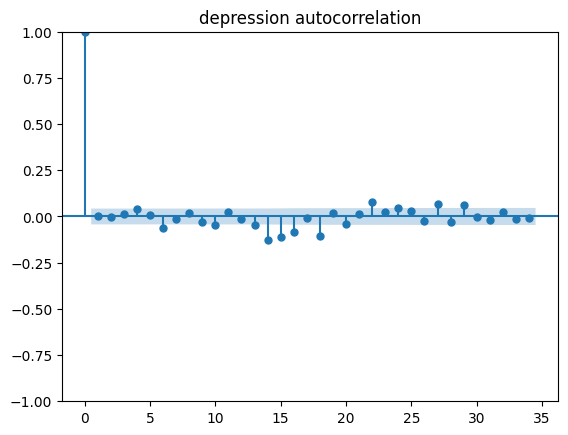

<Figure size 640x480 with 0 Axes>

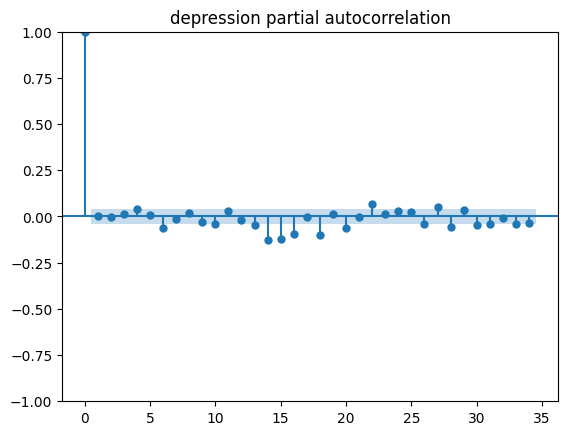

<Figure size 640x480 with 0 Axes>

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14110.582, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15046.682, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14514.188, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14110.079, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15044.683, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14112.075, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14112.075, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14111.335, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=14108.080, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14110.075, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=14110.075, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=14512.189, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=14109.335, Time=0.17 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.181 seconds
         

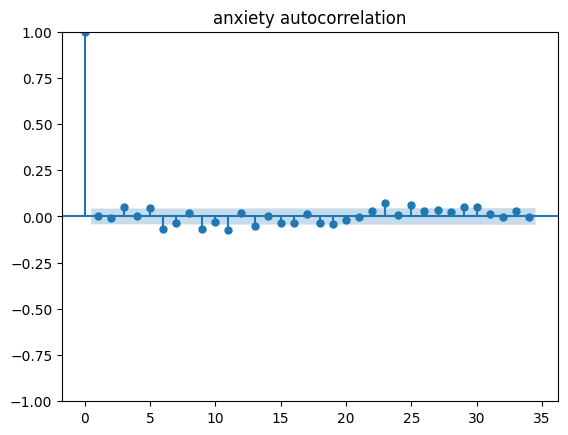

<Figure size 640x480 with 0 Axes>

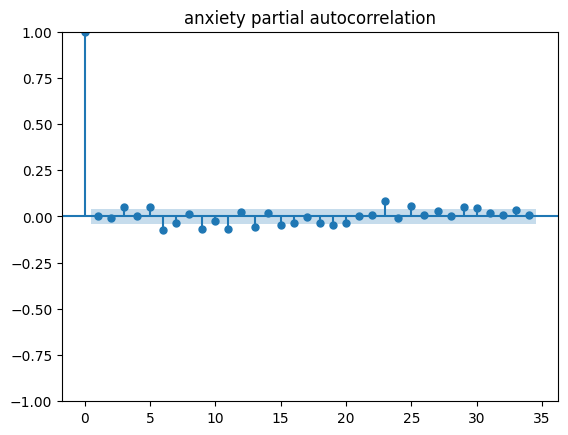

<Figure size 640x480 with 0 Axes>

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12537.606, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13748.993, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13072.521, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12557.701, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13746.993, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12538.593, Time=0.66 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12551.059, Time=0.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=12537.458, Time=1.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12546.781, Time=0.51 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=12519.348, Time=1.38 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=12547.659, Time=0.77 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=12518.220, Time=1.60 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=12547.736, Time=0.89 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=12509.422, Time=1.48 sec
 ARIMA(4,1,3)(0,0,0

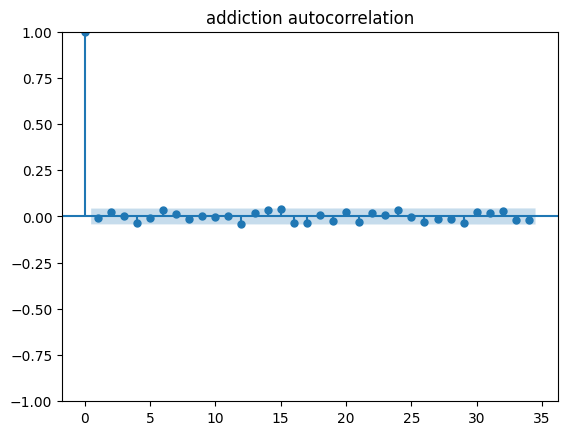

<Figure size 640x480 with 0 Axes>

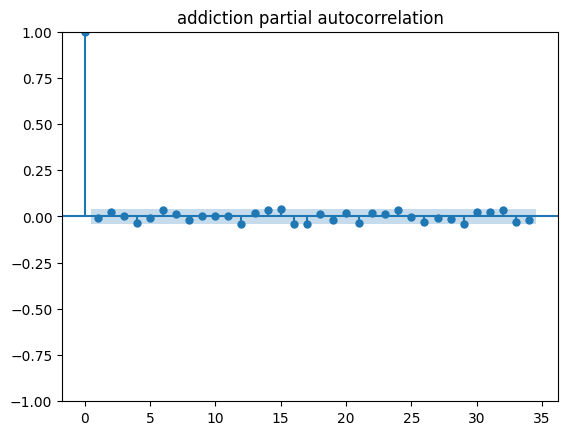

<Figure size 640x480 with 0 Axes>

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13828.769, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14710.826, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14272.274, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13883.132, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14708.826, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13826.776, Time=0.85 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=13867.874, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13863.880, Time=0.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=13828.767, Time=1.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=13867.313, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13856.294, Time=0.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=13840.939, Time=1.90 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=13824.776, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=13865.874, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0

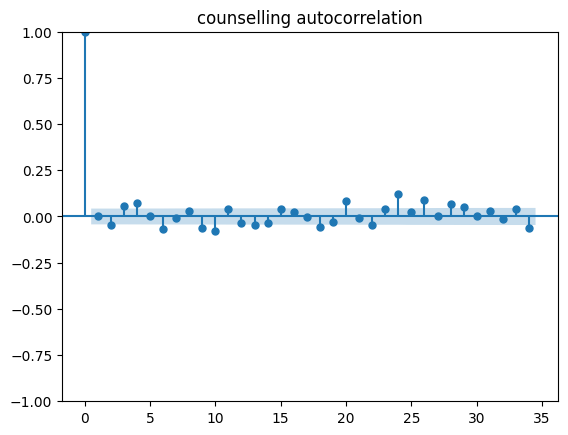

<Figure size 640x480 with 0 Axes>

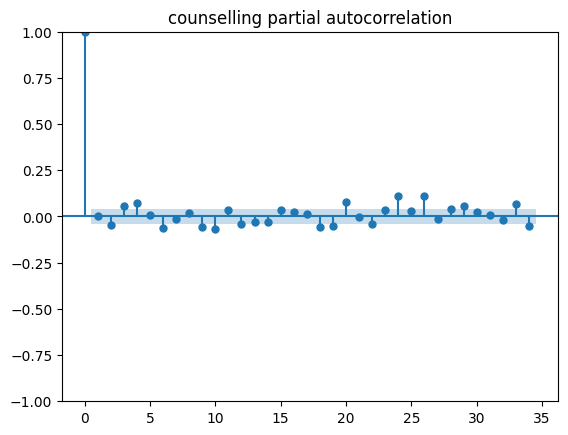

<Figure size 640x480 with 0 Axes>

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14131.886, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14857.758, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14460.682, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14175.298, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14855.761, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14130.239, Time=0.93 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14165.012, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14163.846, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14131.788, Time=1.23 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=14166.198, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14158.842, Time=0.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=14166.042, Time=1.69 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=14128.306, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=14163.027, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0

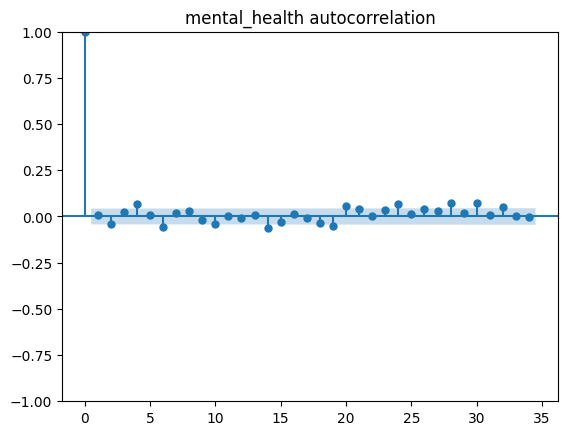

<Figure size 640x480 with 0 Axes>

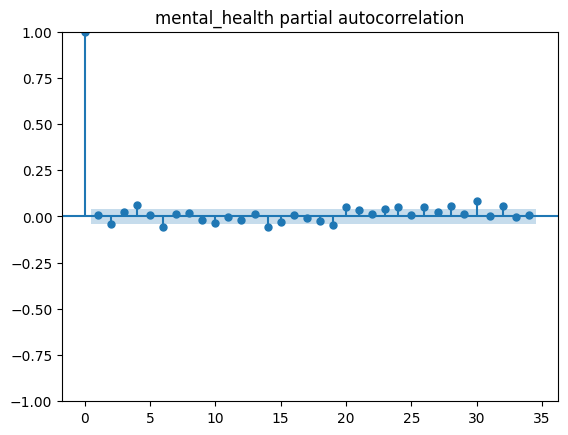

<Figure size 640x480 with 0 Axes>

In [16]:
for search in searches:
    
    model = auto_arima(Least_Restrictions[search], trace=True, error_action='ignore', suppress_warnings=True)
    print(model.summary())
    %matplotlib inline

    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

    residuals = model.resid()
    
    
    
   
    plot_acf(residuals)
    plt.title(f'{search} autocorrelation')
    plt.figure()
    
    

    
    plot_pacf(residuals)
    plt.title(f'{search} partial autocorrelation')
    plt.figure()
    
    

    plt.show()

##### Params provided will be tested in anohter notebook with SARIMAX

In [17]:
# load your time series data
Most_Restrictions = all_states.copy()
Most_Restrictions['week'] = pd.to_datetime(Most_Restrictions['week'],format='%Y-%m-%d')
Most_Restrictions = Most_Restrictions.set_index('week')

In [18]:
Most_Restrictions = Most_Restrictions[Most_Restrictions.covid_restrictions != 'Most Restrictions'].copy()
Most_Restrictions.drop('state', axis=1, inplace=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15028.531, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15658.737, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15281.295, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15032.394, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15656.737, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15026.557, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15024.609, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=15026.573, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15024.557, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15026.557, Time=0.39 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15133.142, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=15022.571, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15030.407, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=15279.299, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0

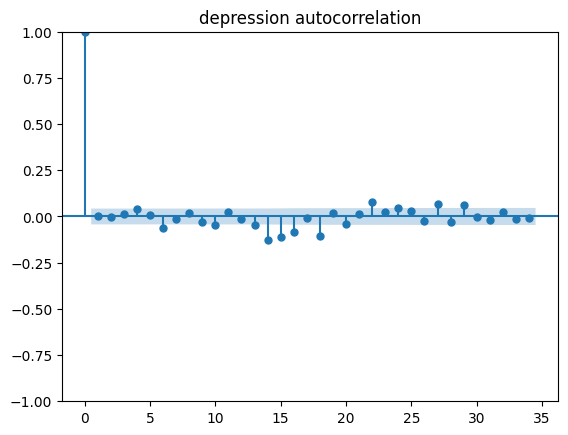

<Figure size 640x480 with 0 Axes>

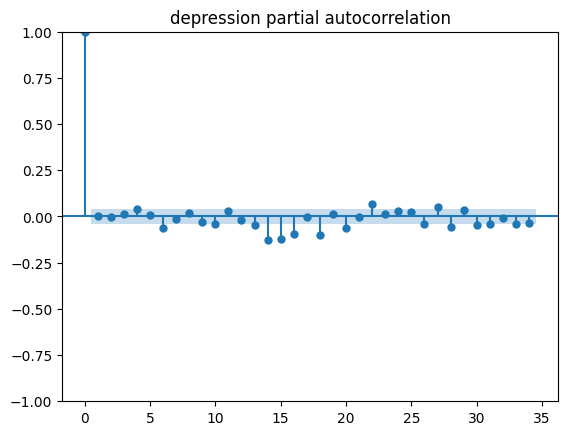

<Figure size 640x480 with 0 Axes>

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14110.582, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15046.682, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14514.188, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14110.079, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15044.683, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14112.075, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14112.075, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14111.335, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=14108.080, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14110.075, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=14110.075, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=14512.189, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=14109.335, Time=0.17 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.094 seconds
         

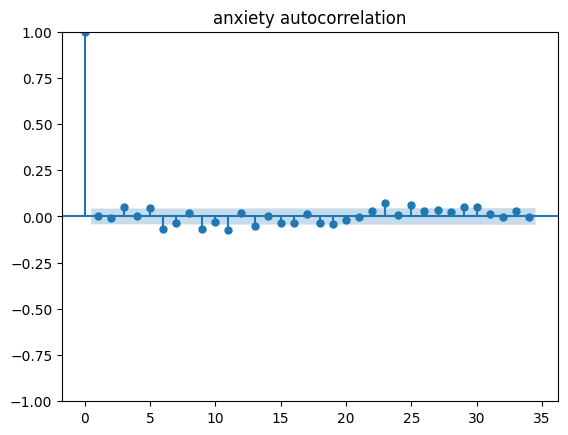

<Figure size 640x480 with 0 Axes>

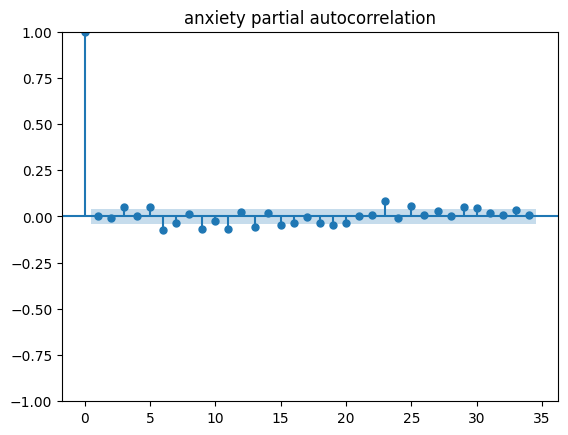

<Figure size 640x480 with 0 Axes>

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12537.606, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13748.993, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13072.521, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12557.701, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13746.993, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12538.593, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12551.059, Time=0.47 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=12537.458, Time=1.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12546.781, Time=0.55 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=12519.348, Time=1.43 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=12547.659, Time=0.79 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=12518.220, Time=1.63 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=12547.736, Time=0.90 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=12509.422, Time=1.47 sec
 ARIMA(4,1,3)(0,0,0

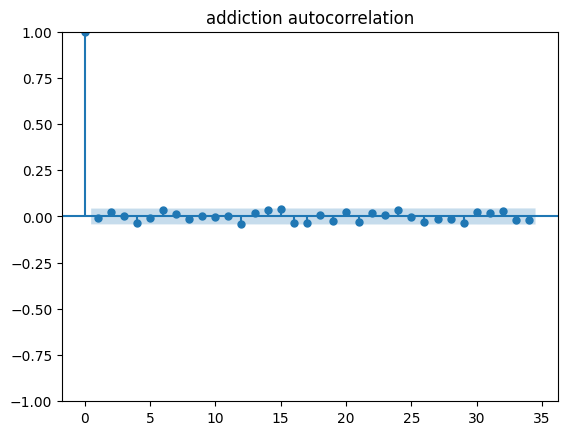

<Figure size 640x480 with 0 Axes>

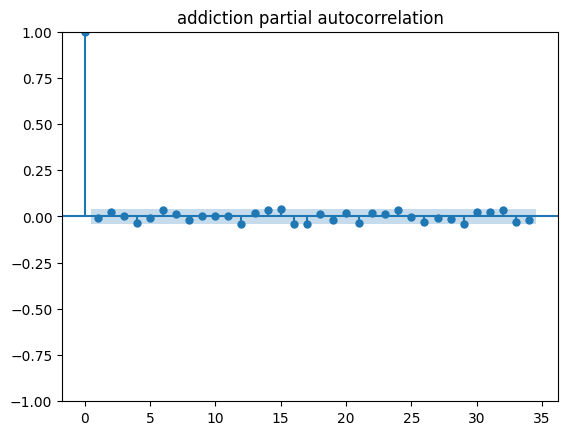

<Figure size 640x480 with 0 Axes>

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13828.769, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14710.826, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14272.274, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13883.132, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14708.826, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13826.776, Time=0.83 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=13867.874, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13863.880, Time=0.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=13828.767, Time=1.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=13867.313, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13856.294, Time=0.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=13840.939, Time=1.90 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=13824.776, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=13865.874, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0

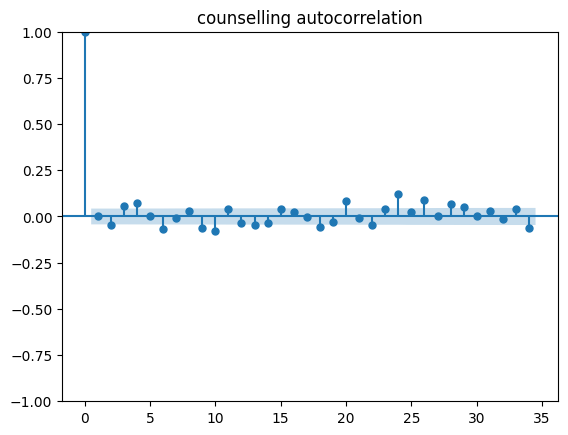

<Figure size 640x480 with 0 Axes>

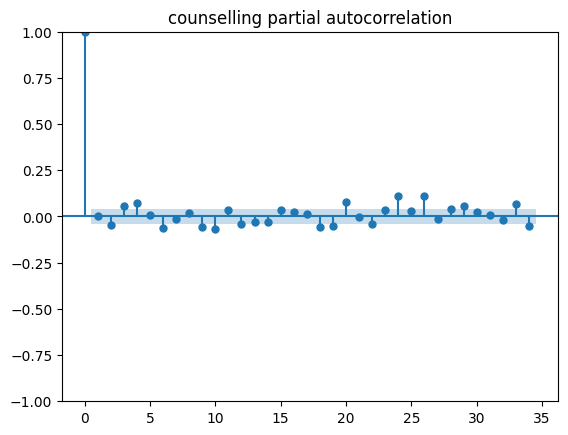

<Figure size 640x480 with 0 Axes>

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14131.886, Time=1.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14857.758, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14460.682, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14175.298, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14855.761, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14130.239, Time=0.92 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14165.012, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14163.846, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14131.788, Time=1.25 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=14166.198, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14158.842, Time=0.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=14166.042, Time=1.53 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=14128.306, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=14163.027, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0

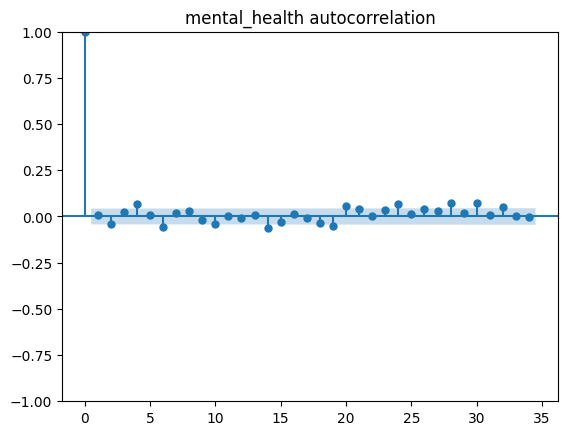

<Figure size 640x480 with 0 Axes>

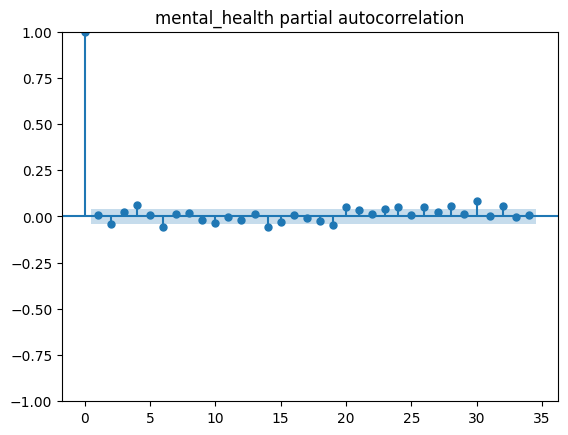

<Figure size 640x480 with 0 Axes>

In [19]:
for search in searches:
    
    model = auto_arima(Most_Restrictions[search], trace=True, error_action='ignore', suppress_warnings=True)
    print(model.summary())
    %matplotlib inline

    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

    residuals = model.resid()
    
    
    
   
    plot_acf(residuals)
    plt.title(f'{search} autocorrelation')
    plt.figure()
    
    

    
    plot_pacf(residuals)
    plt.title(f'{search} partial autocorrelation')
    plt.figure()
    
    

    plt.show()

### Trend Detection with greykite

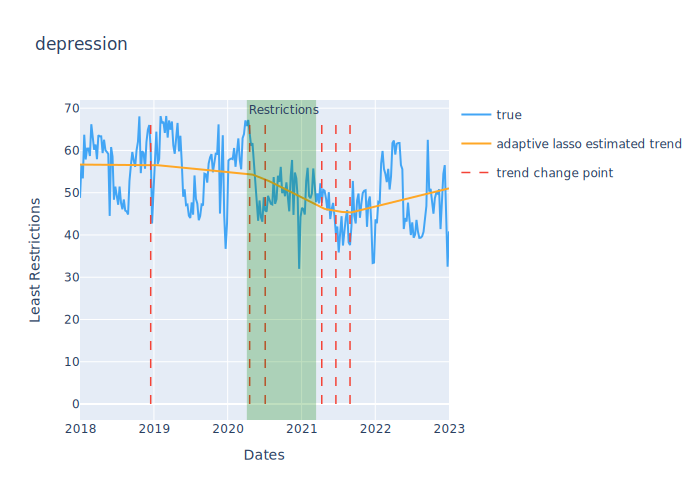

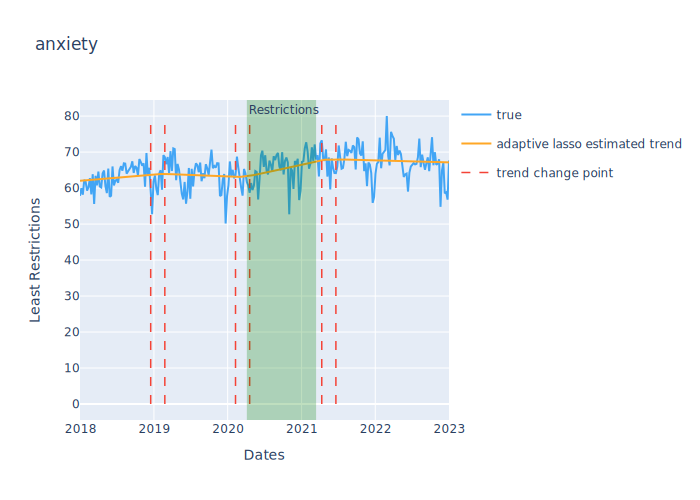

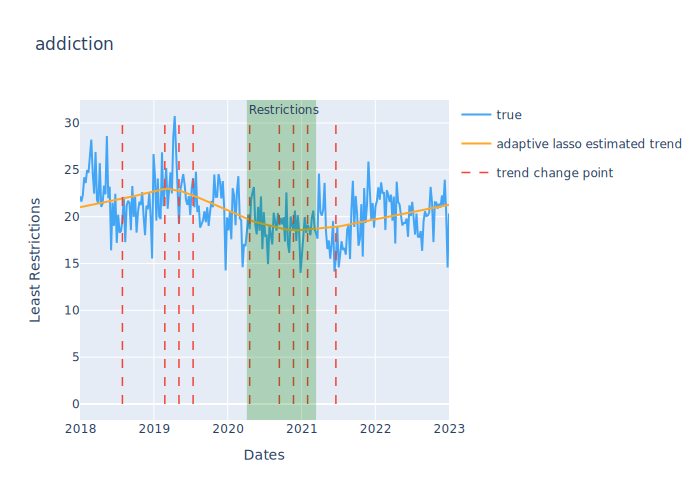

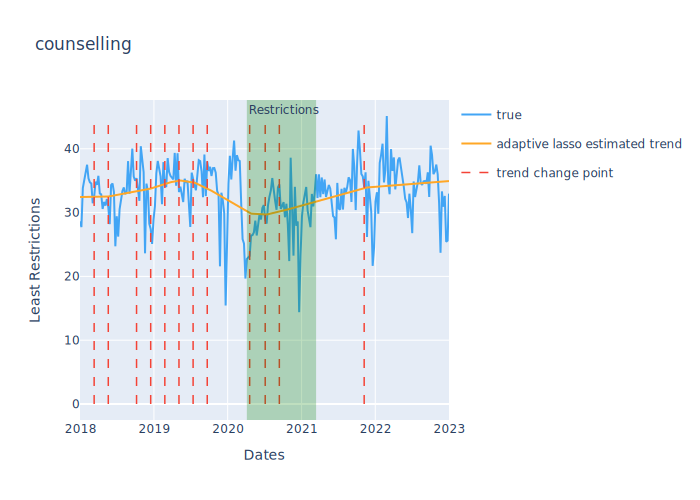

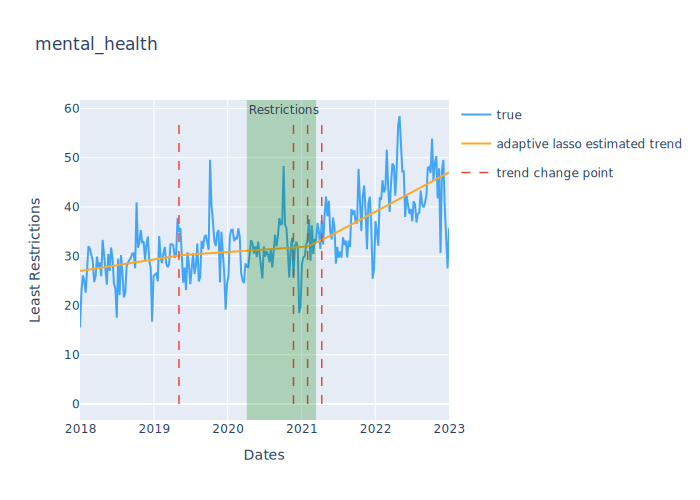

In [20]:
value_columns = ['depression', 'anxiety', 'addiction','counselling','mental_health']

for value_col in value_columns:

    new_df = all_states.groupby(['week', 'covid_restrictions']).mean(numeric_only=True).unstack('covid_restrictions')[value_col]
    model = ChangepointDetector()
    res = model.find_trend_changepoints(
        df=new_df.reset_index(), 
        time_col="week", 
        value_col='Least Restrictions', 
        yearly_seasonality_order=10,
        regularization_strength=0.5, 
        resample_freq="7D", 
        potential_changepoint_n=25, 
        yearly_seasonality_change_freq="365D",
        no_changepoint_distance_from_end="365D")
    fig = model.plot(
        observation=True,
        trend_estimate=False,
        trend_change=True,
        yearly_seasonality_estimate=False,
        adaptive_lasso_estimate=True,
        plot=False,
        )
    fig.add_vrect(x0='2020-04-05', x1="2021-03-14", 
              annotation_text="Restrictions", annotation_position="top left",
              fillcolor="green", opacity=0.25, line_width=0)

    fig.update_layout(title=value_col)
    fig.show("svg")
    #plotly.io.show(fig)

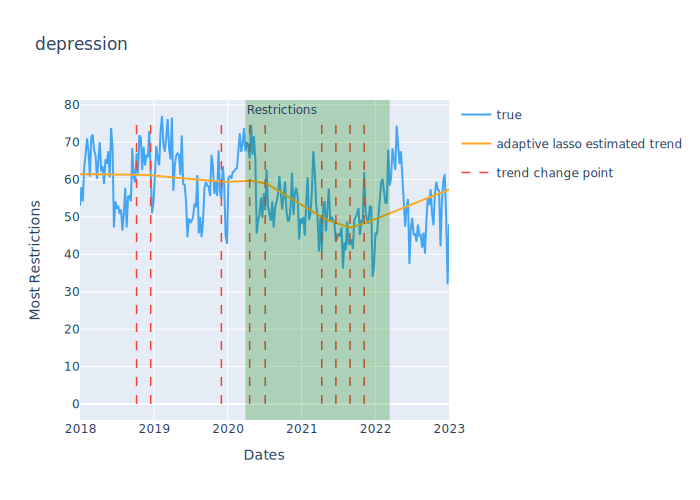

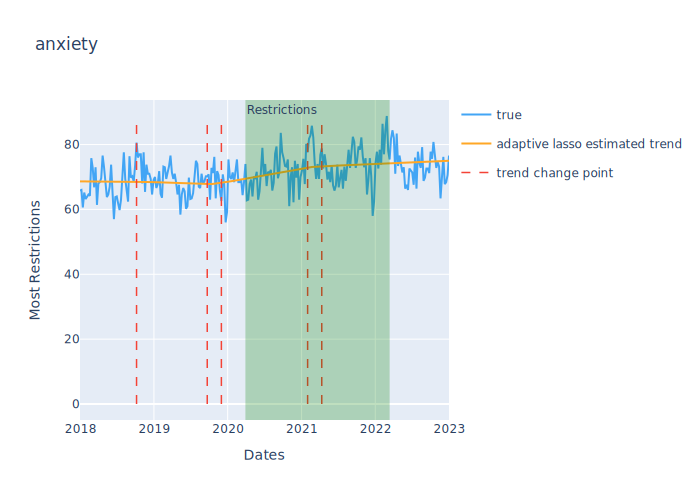

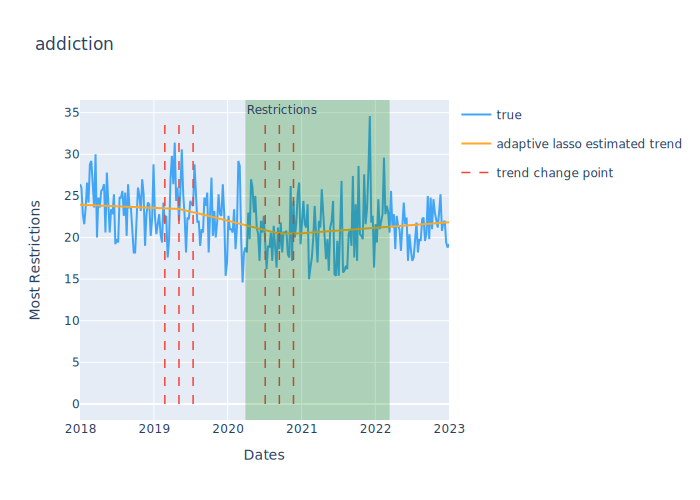

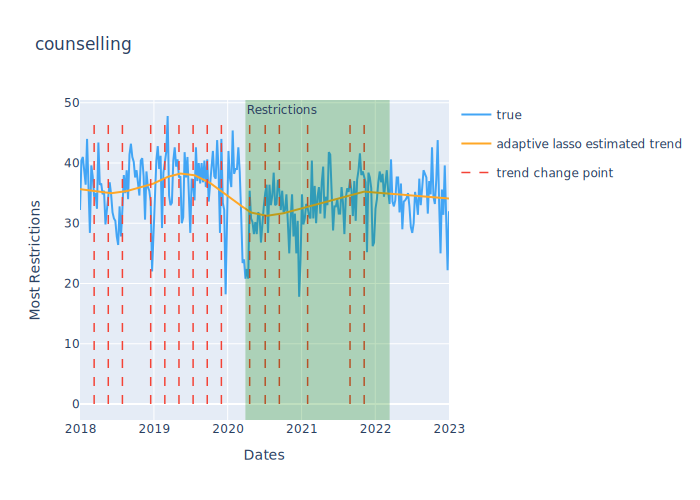

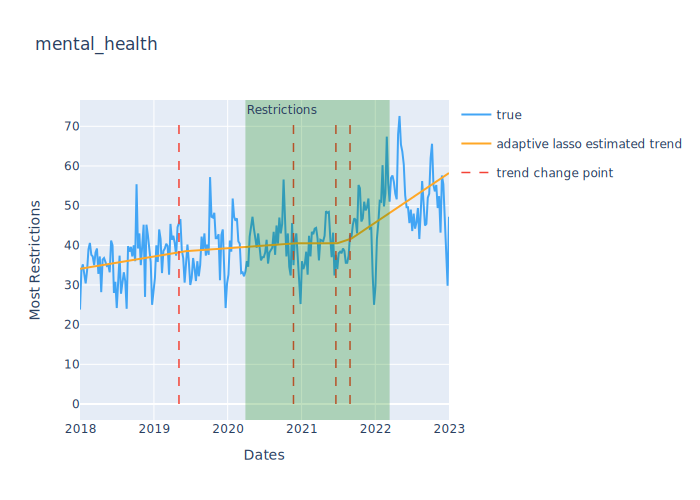

In [21]:
value_columns = ['depression', 'anxiety', 'addiction','counselling','mental_health']

for value_col in value_columns:

    new_df = all_states.groupby(['week', 'covid_restrictions']).mean(numeric_only=True).unstack('covid_restrictions')[value_col]
    model = ChangepointDetector()
    res = model.find_trend_changepoints(
        df=new_df.reset_index(), 
        time_col="week", 
        value_col='Most Restrictions', 
        yearly_seasonality_order=10,
        regularization_strength=0.5, 
        resample_freq="7D", 
        potential_changepoint_n=25, 
        yearly_seasonality_change_freq="365D",
        no_changepoint_distance_from_end="365D")
    fig = model.plot(
        observation=True,
        trend_estimate=False,
        trend_change=True,
        yearly_seasonality_estimate=False,
        adaptive_lasso_estimate=True,
        plot=False,
     
    )
    fig.add_vrect(x0='2020-03-29', x1="2022-03-13", 
              annotation_text="Restrictions", annotation_position="top left",
              fillcolor="green", opacity=0.25, line_width=0)

    fig.update_layout(title=value_col)
    fig.show("svg")
   # plotly.io.show(fig)

#### Search trends for the most and least restricted states are similar. Trend changepoints do not appear to be tied to restriction timeframe in a meaningful way. 